In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
#import strax
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd
import patrick_stylez as ps
from scipy.stats import chi2 

Using TensorFlow backend.


In [9]:

s1_all_runs = {}
s2_all_runs = {}
drifttime_all_runs = {}

lifetime_list = []
lifetime_error_list = []

run_list = ['00159','00220', '00230', '00240', '00250']
#run_list = ['00218', '00219', '00220', '00221', '00222', '00223','00224','00225','00226','00227','00228','00229','00230','00231','00232', '00233','00234',
           #'00235','00236','00237','00238','00239','00240','00241','00242','00243','00244','00245','00246','00247','00248','00249']

for run in run_list:

    def CutCondition(waveform):  
        FirstPeak_area = sum(waveform[:15])
        SecondPeak_area = sum(waveform[15:])    
        if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
            return(True)
        else:
            return(False)
    
    def S2_found(integral, width):
        if integral > 500 and width >200 and width < 2000:
            return True
        else:
            return False
    
    def poisson_interval(k, alpha=0.318):
        a = alpha
        low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
        if k == 0:
            low = 0.0
        low_interval = k - low
        high_interval = high - k
        return low_interval, high_interval

    def single_gaus(x, h, mu, sigma):

        gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
        return gaus
    
    def expo(x, a, b):
        return a*np.exp(-b*x)

    def Process(waveform, i): 
        SelectionCutFlag = CutCondition(waveform[i])
        if SelectionCutFlag == True:
            j = 1
            counter_timestamp = timestamp[i+j]
            threshold_timestamp = timestamp[i] + 45000
            while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
                j += 1
                counter_timestamp = timestamp[i+j]
            else:
                if S2_found(integral = integral[i+j], width = width[i+j]):

                    k=1 
                    s2_counter_timestamp = timestamp[i+j+k]
                    while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                        k += 1
                        s2_counter_timestamp = timestamp[i+j+k]
                    else:
                        if threshold_timestamp <= s2_counter_timestamp:
                            s1.append(integral[i])
                            s2.append(integral[i+j])
                            time       = timestamp[i+j] - timestamp[i]
                            drifttime.append(time)
                        
#                         if threshold_timestamp <= s2_counter_timestamp \
#                         and area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
#                         and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
#                         and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
#                         and area_per_channel[i+j][7] > 0 \
#                         :
#                             s1.append(integral[i])
#                             s2.append(integral[i+j])
#                             time       = timestamp[i+j] - timestamp[i]
#                             drifttime.append(time)
                            
    ctx = straxbra.XebraContext()

    peaks_data = ctx.get_array(run, 'peaks')
    waveform = peaks_data['data']
    integral = peaks_data['area']
    width = peaks_data['width'][:,5]
    timestamp = peaks_data['time']
    area_per_channel = peaks_data['area_per_channel']

    s1 = []
    s2 = []
    drifttime = []
    num = len(waveform)
    print_counter = 0.0
    for i in range(0,num-10):    
        Process(waveform,i)
        if i/num >= print_counter:
            print(round(print_counter,2), end = ' ')
            print_counter += 0.1
    print(1.0, '        Run ',run, 'done!')

    s1_all_runs.update({run:s1})
    s2_all_runs.update({run:s2})
    drifttime_all_runs.update({run:drifttime})
    
    
    
    
    s1 = np.array(s1_all_runs[run])
    s2 = np.array(s2_all_runs[run])
    drifttime = np.array(drifttime_all_runs[run])


    bins_x = np.linspace(0,50,50)
    bins_y = np.logspace(2,4.5,50)
    counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
    xcenter = ((xedges[:-1]+xedges[1:])/2)
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    
    #poisson_list = []
    poisson_list_left = []
    poisson_list_right = []
    
    
    for i in counts:
        error_per_slice_left = []
        error_per_slice_right = []
        for j in i:
            b =poisson_interval(j)[1]
            a =poisson_interval(j)[0]
            error_per_slice_left.append(a)
            error_per_slice_right.append(b)
        poisson_list_left.append(error_per_slice_left)
        poisson_list_right.append(error_per_slice_right)
    
    
    
#     for i in counts:
#         error_per_slice = []
#         for j in i:
#             a =poisson_interval(j)[1]
#             error_per_slice.append(a)
#         poisson_list.append(error_per_slice)
    
    fit_range= np.linspace(500,30000,1000)
    p0 = [50,8,2]

    expectation_list = []
    error_list = []




    for i in range(5,35):   
        popt, pcov = curve_fit(single_gaus, ycenter, counts[i], p0,sigma=np.maximum(np.sqrt(counts[i]), np.ones_like(counts[i])), maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))

    
    
        expectation = np.exp(popt[1]+((popt[2]**2)/2))
        expectation_list.append(expectation)

    
        diff_mu = expectation
        diff_sigma = expectation*popt[2]
        error_mu = perr[1]
        error_sigma = perr[2]
    
        error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
        error_list.append(error)

    





    p0=  [10000,0.1]
    x = np.linspace(5,35,30)



    popt, pcov = curve_fit(expo, x, expectation_list, sigma=error_list, p0=p0, absolute_sigma=True, maxfev= 10000)
    lifetime = 1/popt[1]
    lifetime_list.append(lifetime)
    lifetime_error = (1/(popt[1]**2))*perr[1]
    lifetime_error_list.append(lifetime_error)




    # lifetime = "%.2f" % (1/popt[1])
    # lifetime_error = "%.2f" % ((1/(popt[1]**2))*perr[1])




 

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00159 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00220 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00230 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00240 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00250 done!


In [10]:
print(lifetime_list)
print(lifetime_error_list)

[275.9289189158162, 43.08337740464607, 12.200492143009326, 46.46505829841189, 77.06701179141466]
[1250.6901308182419, 18.906927617361426, 1.884156826241989, 26.60568807359237, 66.98264624462716]


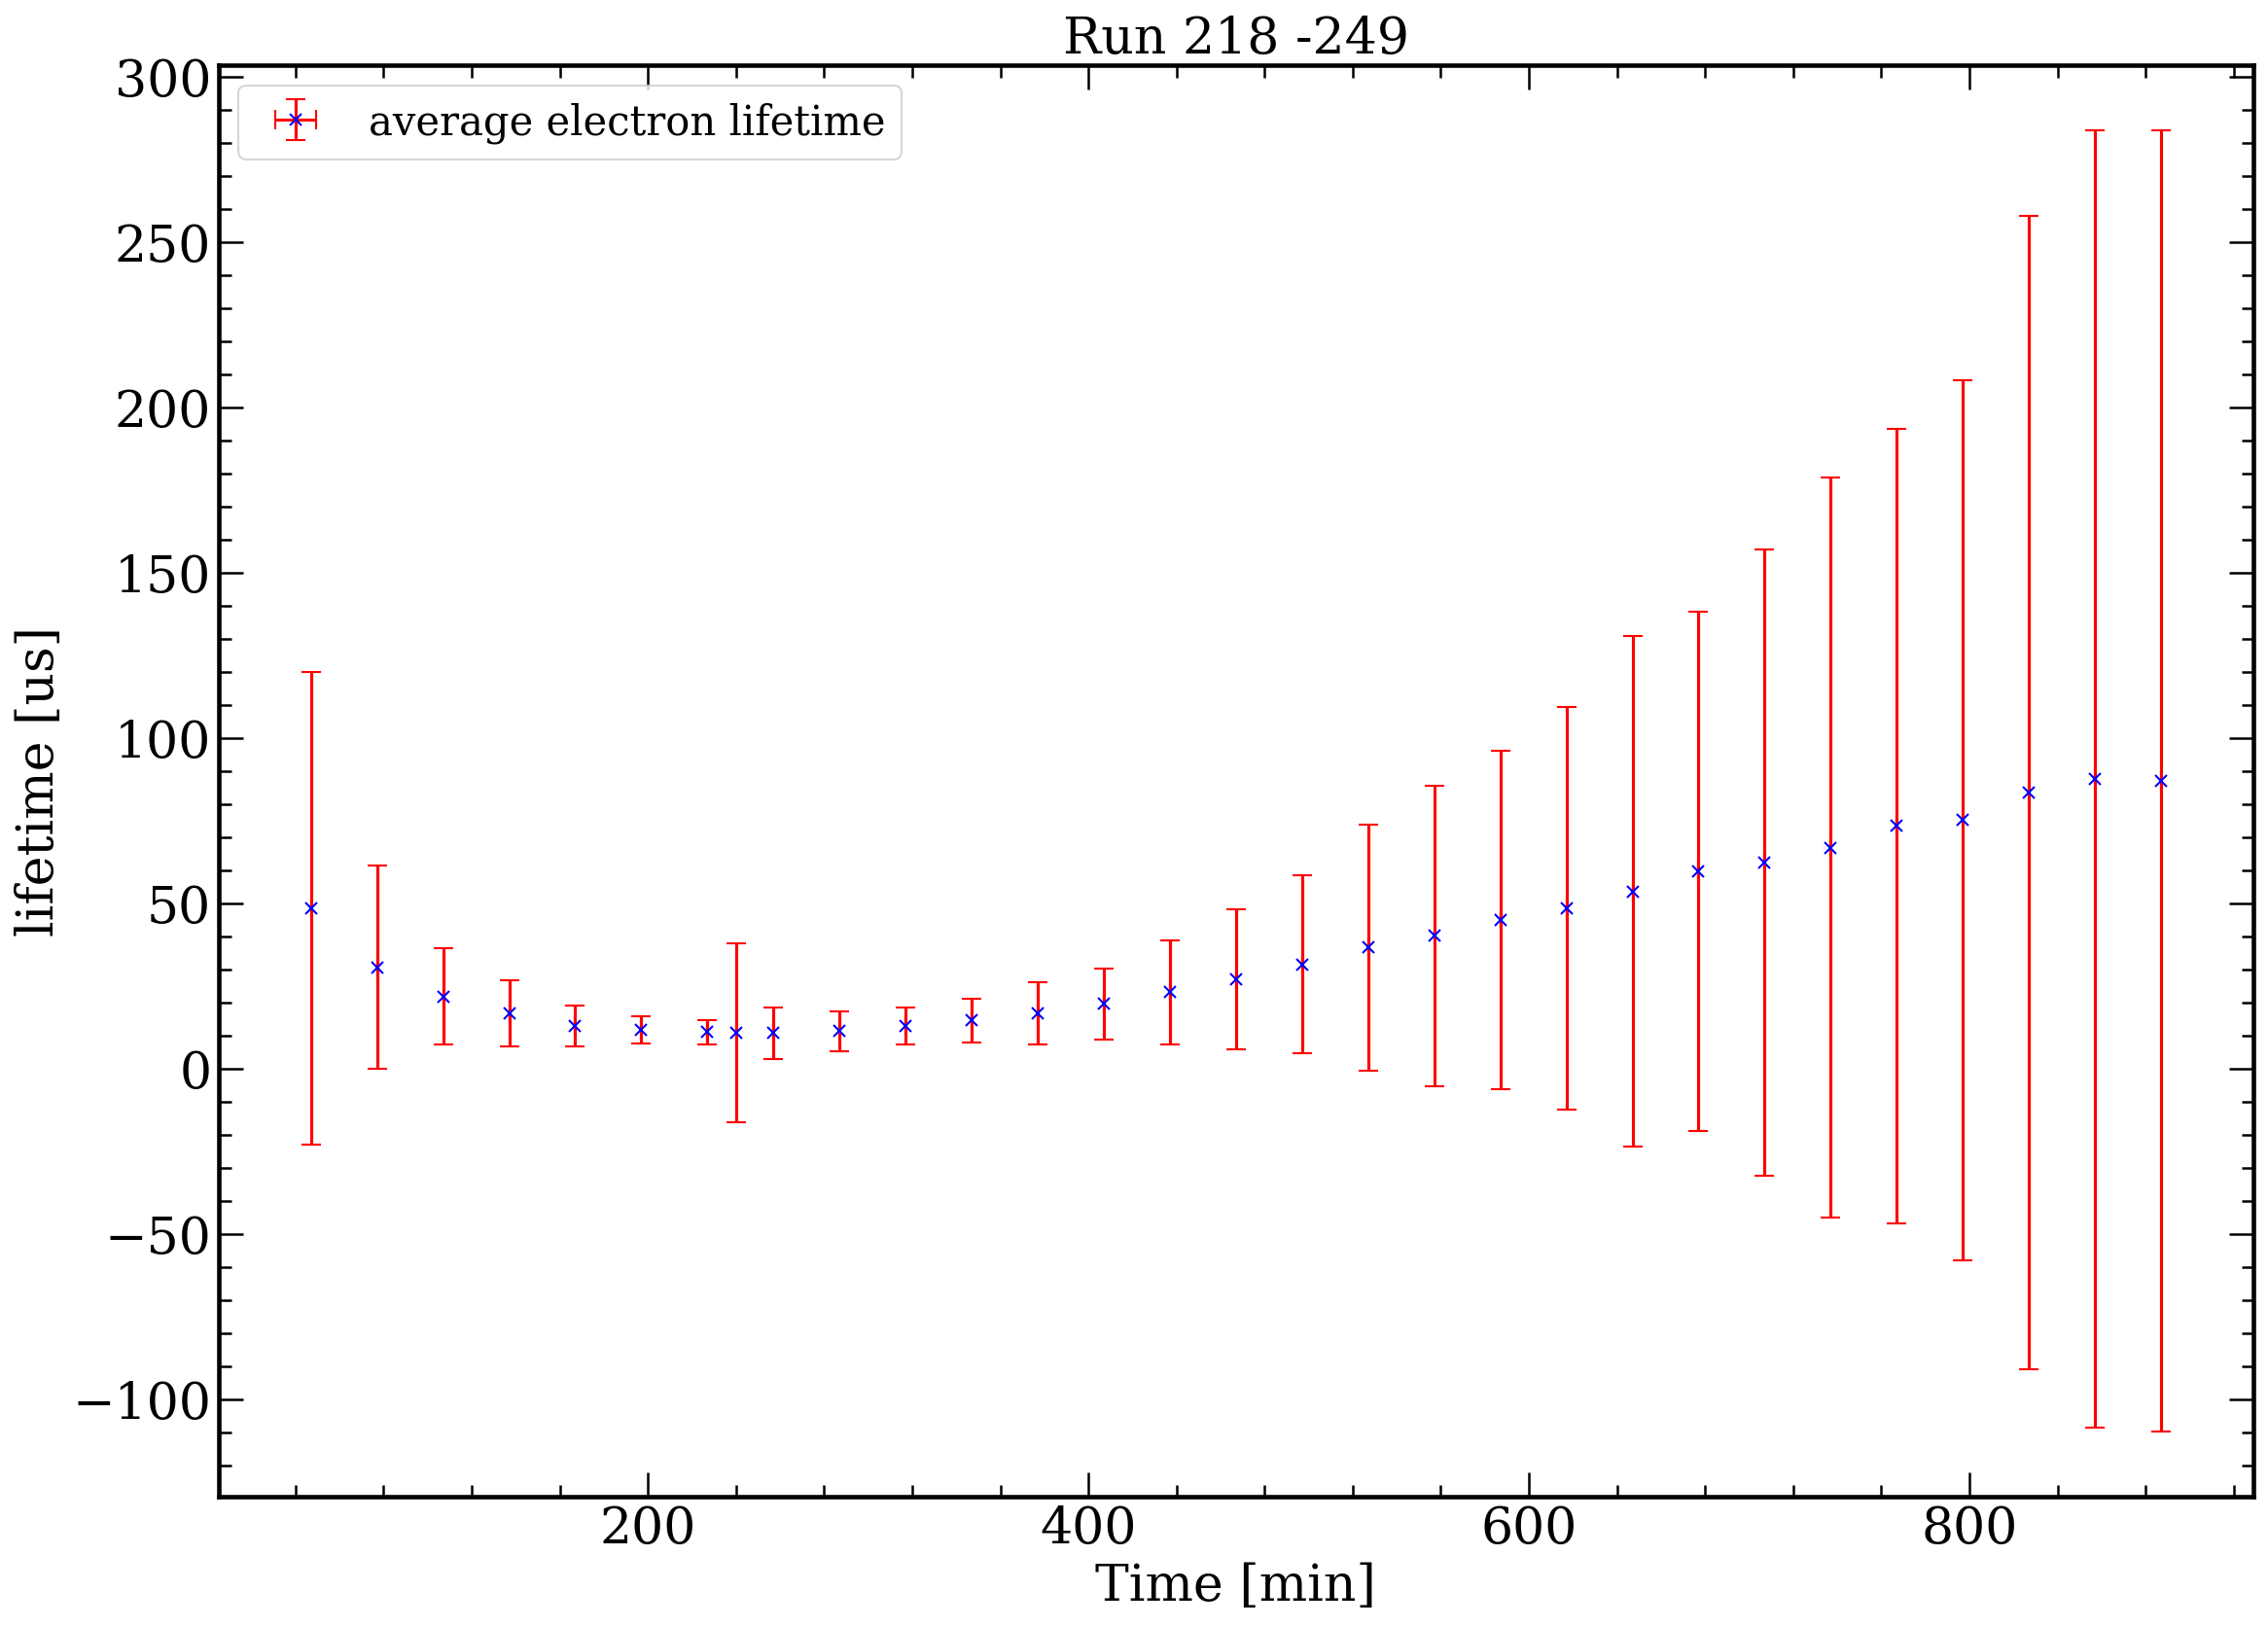

In [28]:
fig, axes = ps.styles()

Time = [0,17,47,77,107,137,167,197,227, 240, 257,287, 317,347,377,407,437,467,497,527,557,587,617,647,677,707,737,767,797,827, 857,887]
plt.errorbar(Time[2:], lifetime_list[2:], yerr=lifetime_error_list[2:], xerr=0, ecolor='red', capsize=5, fmt = 'bx', label = 'average electron lifetime' )
Electron_lifetime_on = lifetime_list[9:]
Electron_lifetime_off = lifetime_list[:8]
Electron_lifetime_off_error = lifetime_error_list[:8]
Time_off = Time[:8]
Time_on = Time[9:]
Time_range_off = np.linspace(0,240,100)
def expo_off(x, a, b):
    return a*np.exp(-b*x)

# p0= [100, 0.1]
# bounds_off = ((100,0),(500, np.inf))

# popt_off, pcov_off = curve_fit(expo_off, Time_off, Electron_lifetime_off,sigma=Electron_lifetime_off_error, p0=p0, bounds = bounds_off, absolute_sigma=True, maxfev= 10000)
#axes.axvline(x=240, ymin=0, ymax=2, linestyle = '--', label ='start purification')
axes.set_title('Run 218 -249')
axes.set_xlabel('Time [min]')
axes.set_ylabel('lifetime [us]')
# plt.plot(Time_range_off, expo_off(Time_range_off, *popt_off), 'y--', label= 'getter off')
# m,b = np.polyfit(Time_on,Electron_lifetime_on , 1)
# m = "%.2f" % m
# fit=np.polyfit(Time_on,Electron_lifetime_on , 1)
# fit_fn = np.poly1d(fit)
# plt.plot(Time_on, fit_fn(Time_on), 'g--', label = 'getter on: m = '+str(m))
# axes.axvline(x=240, ymin=0, ymax=2, linestyle = '--', label ='start purification')
plt.legend(prop={'size': 20})
plt.show()